In [35]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *
from scripts.mane_utils import *

In [36]:
config_file = '../snakemake/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [46]:
ab = '../'+expand(config['data']['ab'], species='human')[0]
filt_ab = '../'+expand(config['data']['filt_ab'], species='human')[0]
read_annot = '../'+expand(config['data']['read_annot'], species='human')[0]
t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='human')[0]
lib_meta = '../'+expand(config['data']['meta'], species='human')[0]
swan_file = '../'+expand(config['data']['sg'], species='human')[0]
cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='human')[0]
cerb_t_metadata = '../'+expand(config['data']['t_info'], species='human')[0]
major_isos = '../'+expand(config['data']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]
ref_t_metadata = '../'+expand(config['ref']['t_info'], species='human')[0]
ref_g_metadata = '../'+expand(config['ref']['g_info'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'polya'
obs_col = 'sample'
go_gene_subset = 'protein_coding'
predom_iso_subset = 'protein_coding'

m_lib_meta = '../'+expand(config['data']['meta'], species='mouse')[0]
m_ab = '../'+expand(config['data']['ab'], species='mouse')[0]
m_filt_ab = '../'+expand(config['data']['filt_ab'], species='mouse')[0]
m_read_annot = '../'+expand(config['data']['read_annot'], species='mouse')[0]
m_t_metadata = '../'+expand(config['ref']['cerberus']['t_info'], species='mouse')[0]
m_swan_file = '../'+expand(config['data']['sg'], species='mouse')[0]
m_cerberus_h5 = '../'+expand(config['data']['cerb_annot'], species='mouse')[0]
m_pi_tpm_table = '../'+expand(config['data']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='mouse')[0]
m_ref_t_metadata = '../'+expand(config['ref']['t_info'], species='mouse')[0]
m_ref_g_metadata = '../'+expand(config['ref']['g_info'], species='mouse')[0]
m_major_isos = '../'+expand(config['data']['major_isos'], species='mouse', obs_col='sample')[0]


mouse_ver = 'vM25_cerberus'

In [59]:
def get_cds(exons, orf_start, orf_end, strand):
    # ChatGPT wrote most of this thx friend
    
    def rev_exons(exons):
        return [(e[1],e[0]) for e in exons[::-1]]
    
    if strand == '-':
        exons = rev_exons(exons)
        orf_start, orf_end = orf_end, orf_start
        
    cds = []
    for exon_start, exon_end in exons:
       
        # determine the overlap between the current exon and the ORF
        overlap_start = max(exon_start, orf_start)
        overlap_end = min(exon_end, orf_end)
        
        # if there is no overlap, skip this exon
        if overlap_start > overlap_end:
            continue
        
        # add the CDS range for this exon to the list
        cds.append((overlap_start, overlap_end))
        
    if strand == '-':
        cds = rev_exons(cds)
    
    return cds

def add_bool_heatmap(tpm_df, ax, species):
    # tpm_df['is_mane_orf'] = False
    keep_cols = ['triplet', 'gene_name', 'is_mane_orf',
                 'full_orf', 'nmd', 'Known']
    temp = tpm_df[keep_cols]
    temp['iso_trip'] = temp.gene_name+' '+temp.triplet
    temp.drop(['triplet', 'gene_name'], axis=1, inplace=True)
    temp.set_index('iso_trip', inplace=True)
    temp.index.name = ''
    temp.rename({'is_mane_orf': 'MANE ORF',
                 'full_orf': 'Full ORF',
                 'nmd': 'NMD'}, axis=1, inplace=True)
    # bool_cols = ['is_mane_orf', 'full_orf', 'nmd', 'Known']
    bool_cols = ['Known', 'MANE ORF', 'Full ORF', 'NMD']
    temp = temp[bool_cols]
    temp2 = pd.DataFrame()
    
    m = {True: '*', False: ''}
    for c in bool_cols:
        temp2[c] = temp[c].map(m)
    
    pdb.set_trace()
    
    if species == 'mouse':
        temp.drop('MANE ORF', axis=1, inplace=True)
        temp2.drop('MANE ORF', axis=1, inplace=True)

    ax = sns.heatmap(temp, cbar=False, cmap='Purples',
                     linewidths=0.5, linecolor='k',
                     annot=temp2, square=True, 
                     fmt='', ax=ax)
    ax.tick_params(left=False,
                   right=False, labelright=False,
                   bottom=False, labelbottom=False,
                   labeltop=True)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    return ax

def plot_browser_isos(ca, sg, gene,
                      obs_col, obs_condition, 
                      filt_ab, pp_summary, 
                      major_set,
                      h=0.1, w=56, fig_w=14, species='human',
                      add_tss=False,
                      add_ccre=False,
                      major=False,
                      order='expression',
                      light_shade=None,
                      dark_shade=None):
    """
    Plot browser style isoform models for a given sample
    """

    def plot_tss(ca, sg, tpm_df, x, y, h, ax):
        tpm_df = add_feat(tpm_df, kind='tss', col='transcript_id')
        tpm_df.head()
        tss_df = ca.tss.loc[ca.tss.Name.isin(tpm_df.tss.tolist())]
        tss_df.head()
        regions = [(entry.Start, entry.End) for ind, entry in tss_df.iterrows()]
        color = get_sector_colors()[0]['tss']
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
        return ax
    
    def plot_cds(entry, sg, x, y, h, ax, color):
        c_dict, order = get_sector_colors()
        
        def get_inc_region(entry, how, scale):
            inc = 80
            if how == 'start' and entry.Strand == '+':
                col = 'CDS_Start'
            elif how == 'stop' and entry.Strand == '+':
                col = 'CDS_Stop'
            elif how == 'start' and entry.Strand == '-':
                col = 'CDS_Stop'
            elif how == 'stop' and entry.Strand == '-':
                col = 'CDS_Start'
            if entry.Strand == '+':
                regions = (entry[col],entry[col]+inc)
            elif entry.Strand == '-':
                regions = (entry[col],entry[col]-inc)
            regions = [regions]
            # print(f'Scale: {scale}')
            # print(f'CDS inc: {inc}')
            
            return regions 

        # get start and stop 
        strand = entry.Strand
        if strand == '+':
            orf_start = entry['CDS_Start']
            orf_end = entry['CDS_Stop']
        elif strand == '-':
            orf_end = entry['CDS_Start']
            orf_start = entry['CDS_Stop']
        loc_path = sg.pg.loc_path
        exons = [(sg.pg.loc_df.loc[v1, 'coord'],
            sg.pg.loc_df.loc[v2, 'coord']) \
            for v1,v2 in zip(loc_path[:-1],loc_path[1:])][::2]
        cds = get_cds(exons, orf_start, orf_end, strand)
        ax = sg.pg.plot_regions(cds, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
        
        # start codon
        color = c_dict['tss']
        regions = get_inc_region(entry, 'start', sg.pg.scale)
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
        
        # stop codon
        color = c_dict['tes']
        regions = get_inc_region(entry, 'stop', sg.pg.scale)
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, color, ax)
       
        return ax
        

    def plot_ccre(ca, sg, x, y, h, ax):

        # ccre regions
        sources = ['pls', 'pels', 'dels']
        ccre = ca.tss_map.loc[ca.tss_map.source.isin(sources)].copy(deep=True)

        # get ranges w/i this region
        min_coord = sg.pg.g_min
        max_coord = sg.pg.g_max
        chrom = sg.pg.chrom

        ccre['min_coord'] = ccre[['Start', 'End']].min(axis=1)
        ccre['max_coord'] = ccre[['Start', 'End']].max(axis=1)

        # subset on regions
        ccre = pr.PyRanges(ccre)
        region = pr.from_dict({'Chromosome': [chrom],
                                        'Start': [min_coord],
                                        'End': [max_coord]})
        ccre = ccre.intersect(region, strandedness=None)
        ccre = ccre.as_df()

        # colors
        c_dict, _ = get_ccre_colors()
        colors = [c_dict[s] for s in ccre.source.tolist()]
        regions = [(entry.Start, entry.End) for ind, entry in ccre.iterrows()]
        ax = sg.pg.plot_regions(regions, sg.pg.scale, sg.pg.strand, sg.pg.g_min, sg.pg.g_max, x, y, h, colors, ax)

        return ax

    def get_major_isos(major_set, gene, sample=None):
        """
        Get list of major isfoorms in a given sample
        """
        df = pd.read_csv(major_set, sep='\t')
        df = df.loc[df.gname == gene]
        if sample:
            df = df.loc[df['sample'] == sample]
        tids = df.tid.unique().tolist()
        return tids

    def get_isos(ca, filt_ab, gene, sample, species):
        df = pd.read_csv(filt_ab, sep='\t')
        df = get_det_table(df,
                       groupby='sample',
                       how='iso',
                       min_tpm=1,
                       gene_subset='polya',
                       species=species)
        df = df.loc[sample]
        df = df.to_frame()
        df = df.loc[df[sample]==True]
        gid = ca.triplets.loc[ca.triplets.gname==gene, 'gid'].values[0]
        df.reset_index(inplace=True)
        df['gid'] = df['index'].str.split('[', expand=True)[0]
        df = df.loc[df.gid == gid]
        tids = df['index'].tolist()
        return tids


    def get_tpm_df(sg, tids, obs_col, obs_condition):
        tpm_df = swan.calc_tpm(sg.adata, obs_col=obs_col).sparse.to_dense()
        tpm_df = tpm_df.transpose()
        tpm_df = tpm_df.loc[tids, obs_condition].to_frame()
        return tpm_df

    if major:
        tids = get_major_isos(major_set, gene, obs_condition)
    else:
        tids = get_isos(ca, filt_ab, gene, obs_condition, species)
    tpm_df = get_tpm_df(sg, tids, obs_col, obs_condition)

    # colormap definition
    if not light_shade:
        light_shade = get_sector_colors()[0]['mixed']
    if not dark_shade:
        dark_shade = get_sector_colors()[0]['simple']
    cmap = mpl.colors.LinearSegmentedColormap.from_list('', [light_shade, dark_shade])
    
    # figure / subplot settings
    fig_h = len(tids)/4
    w1_rat = (fig_w/6)*2
    w2_rat = (fig_w/6)*4
    fig, (ax, ax2) = plt.subplots(1,2, figsize=(fig_w, fig_h),
                                  gridspec_kw={'width_ratios':(w1_rat, w2_rat)},
                                  frameon=False, sharey=True)
    fig.subplots_adjust(wspace=0.00)
    fig.subplots_adjust(hspace=0.00)
    
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['pdf.fonttype'] = 42

    # plotting order
    tpm_df = tpm_df.sort_values(by=obs_condition, ascending=False)
    tpm_df = tpm_df[[obs_condition]]

    if order == 'tss':
        tpm_df = add_feat(tpm_df, kind='tss', col='index')
        tpm_df.sort_values(by=['tss', obs_condition], ascending=[True, False], inplace=True)
        tpm_df.drop('tss', axis=1, inplace=True)

    # add reference ids
    if species == 'human':
        ref_source = 'v40'
    elif species == 'mouse':
        ref_source = 'vM25'
    df = ca.t_map.loc[ca.t_map.source == ref_source]
    df = df[['transcript_id','original_transcript_id', 'original_transcript_name']]
    tpm_df = tpm_df.merge(df, how='left', left_index=True, right_on='transcript_id')

    # clean up for transcripts that aren't known
    df = ca.t_map.loc[ca.t_map.source == 'lapa']
    df = df[['gene_name', 'transcript_id', 'transcript_name',
             'tss_id', 'ic_id', 'tes_id']].drop_duplicates()
    tpm_df = tpm_df.merge(df, how='left', on='transcript_id')
    tpm_df.fillna('N/A', inplace=True)

    if species == 'human':
        refs = ['v40', 'v29']
    elif species == 'mouse':
        refs = ['vM21', 'vM25']
    known_tids = ca.t_map.loc[ca.t_map.source.isin(refs)].transcript_id.unique().tolist()
    tpm_df['Known'] = tpm_df.transcript_id.isin(known_tids)

    # triplets rather than entire transcript name
    tpm_df['triplet'] = tpm_df.transcript_id.str.split('[', n=1, expand=True)[1]
    tpm_df['triplet'] = tpm_df.triplet.str.split(']', n=1, expand=True)[0]
    tpm_df['triplet'] = '['+tpm_df.triplet+']'
    
    # NMD and ORF 
    pp_df = pd.read_csv(pp_summary, sep='\t')
    pp_df.rename({'tid': 'transcript_id'}, axis=1, inplace=True)
    tpm_df = tpm_df.merge(pp_df[['transcript_id', 'nmd', 'full_orf', 
                                 'seq', 'Strand', 'CDS_Start', 'CDS_Stop']], 
                          how='left', 
                          on='transcript_id')
    
    # are these the mane orf
    if species == 'human':
        tpm_df['gid'] = tpm_df['ic_id'].str.split('_', expand=True)[0]
        gid = tpm_df.gid.values[0]
        mane_orf = get_mane_orf(pp_summary,
                                'v40_cerberus',
                                gid=gid).seq.values[0]
        tpm_df['is_mane_orf'] = tpm_df['seq'] == mane_orf 
    
    # first add the labels
    ax = add_bool_heatmap(tpm_df, ax, species)
    
    # get y coords from heatmap
    y_locs = ax.get_yticks()
    
    # get x coords from heatmap
    x = 0    
    i = 0
    
    # get height of cdss
    h_cds = h*2
    
    linewidth = 1.5
    
    for index, entry in tpm_df.iterrows():
        
        y_ytick = y_locs[i]

        # y coords
        y = y_ytick-(h/2)
        y_cds = y_ytick-(h_cds/2)

        # tid
        tid = entry['transcript_id']
        
        # color by TPM
        if len(tpm_df.index) == 1:
            norm_val = entry[obs_condition]
        else:
            norm_val = (entry[obs_condition]-tpm_df[obs_condition].min())/(tpm_df[obs_condition].max()-tpm_df[obs_condition].min())
        color = cmap(norm_val)
        
        # plot models + cds
        ax2 = sg.plot_browser(tid, y=y, x=x, h=h, w=w, color=color,
                              ax=ax2, linewidth=linewidth)
        ax2 = plot_cds(entry, sg, x, y_cds, h_cds, ax2, color)
        
        i+=1
    
    y_space=0.5
    
    i = 1
    if add_tss:
        y_ytick = (len(tpm_df.index) + i)
        y = y_ytick-(h_cds/2)
        ax2 = plot_tss(ca, sg, tpm_df, x, y, h_cds, ax2)
        i += 1

    if add_ccre:
        y_ytick = (len(tpm_df.index) + i)
        y = y_ytick-(h_cds/2)
        ax2 = plot_ccre(ca, sg, x, y, h_cds, ax2)
        i += 1

    # add scale
    y_ytick = (len(tpm_df.index) + i)
    y = y_ytick-(h_cds/2)
    ax2 = sg.pg.plot_scale(x, y, h_cds, w, ax2, linewidth=linewidth)
    
    print(sg.pg.scale*(250000))
        
    plt.tight_layout()
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_frame_on(False)     
    
    return ax, tpm_df

In [56]:
def plot_browser_isos_2(h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        gene,
                        obs_col,
                        obs_condition,
                        ofile,
                        **kwargs):
    
    ca = cerberus.read(h5)
    sg = swan.read(swan_file)

    ax, tpm_df = plot_browser_isos(ca,
                                   sg,
                                   gene,
                                   obs_col,
                                   obs_condition,
                                   filt_ab,
                                   pp_summary,
                                   major_isos,
                                   h=0.4,
                                   w=10,
                                   fig_w=6,
                                   **kwargs)
    plt.savefig(ofile, dpi=500, bbox_inches='tight')

    return ax, tpm_df

In [49]:
# trying to fix scale issues -- do l8r
# try adj. ax2 ylim to get the scale, ccres, 
# and tsss plotted on there

In [50]:
# _ = plot_browser_isos_2(cerberus_h5,
#                         swan_file,
#                         filt_ab,
#                         pp_summary,
#                         major_isos,
#                         'ACTA1',
#                         obs_col,
#                         'heart',
#                         'acta1.pdf')

Read in graph from ../data/human/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2069: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2068: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples
> <ipython-input-47-5809fb885a5b>(293)plot_browser_isos()
    291 
    292     # first add the labels
--> 293     ax = add_bool_heatmap(tpm_df, ax, species)
    294 
    295     # get y coords from heatmap



ipdb>  c


> <ipython-input-47-5809fb885a5b>(48)add_bool_heatmap()
     46     pdb.set_trace()
     47 
---> 48     m = {True: '*', False: ''}
     49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)



ipdb>  temp


              Known  MANE ORF  Full ORF    NMD
                                              
PKM [1,1,1]    True      True      True  False
PKM [1,46,1]  False     False      True  False
PKM [3,50,1]  False      True      True  False
PKM [1,40,1]  False     False      True   True
PKM [3,51,1]  False     False      True  False
PKM [5,8,1]    True     False      True  False
PKM [1,26,1]  False     False      True  False
PKM [4,7,1]    True     False      True  False
PKM [1,41,1]  False     False      True   True
PKM [1,31,1]  False     False      True  False
PKM [1,27,1]  False      True      True  False
PKM [1,42,1]  False     False      True   True
PKM [1,44,1]  False     False      True   True
PKM [1,3,1]   False     False      True  False
PKM [1,37,1]  False     False      True   True
PKM [2,2,2]    True     False      True  False
PKM [3,46,1]  False     False      True  False
PKM [1,43,1]  False     False      True   True


ipdb>  n


> <ipython-input-47-5809fb885a5b>(49)add_bool_heatmap()
     47 
     48     m = {True: '*', False: ''}
---> 49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)
     51 



ipdb>  n


> <ipython-input-47-5809fb885a5b>(50)add_bool_heatmap()
     48     m = {True: '*', False: ''}
     49     for c in bool_cols:
---> 50         temp2[c] = temp[c].map(m)
     51 
     52     if species == 'mouse':



ipdb>  n


> <ipython-input-47-5809fb885a5b>(49)add_bool_heatmap()
     47 
     48     m = {True: '*', False: ''}
---> 49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)
     51 



ipdb>  n


> <ipython-input-47-5809fb885a5b>(50)add_bool_heatmap()
     48     m = {True: '*', False: ''}
     49     for c in bool_cols:
---> 50         temp2[c] = temp[c].map(m)
     51 
     52     if species == 'mouse':



ipdb>  n


> <ipython-input-47-5809fb885a5b>(49)add_bool_heatmap()
     47 
     48     m = {True: '*', False: ''}
---> 49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)
     51 



ipdb>  n


> <ipython-input-47-5809fb885a5b>(50)add_bool_heatmap()
     48     m = {True: '*', False: ''}
     49     for c in bool_cols:
---> 50         temp2[c] = temp[c].map(m)
     51 
     52     if species == 'mouse':



ipdb>  n


> <ipython-input-47-5809fb885a5b>(49)add_bool_heatmap()
     47 
     48     m = {True: '*', False: ''}
---> 49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)
     51 



ipdb>  n


> <ipython-input-47-5809fb885a5b>(50)add_bool_heatmap()
     48     m = {True: '*', False: ''}
     49     for c in bool_cols:
---> 50         temp2[c] = temp[c].map(m)
     51 
     52     if species == 'mouse':



ipdb>  n


> <ipython-input-47-5809fb885a5b>(49)add_bool_heatmap()
     47 
     48     m = {True: '*', False: ''}
---> 49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)
     51 



ipdb>  n


> <ipython-input-47-5809fb885a5b>(52)add_bool_heatmap()
     50         temp2[c] = temp[c].map(m)
     51 
---> 52     if species == 'mouse':
     53         temp.drop('MANE ORF', axis=1, inplace=True)
     54         temp2.drop('MANE ORF', axis=1, inplace=True)



ipdb>  n


> <ipython-input-47-5809fb885a5b>(56)add_bool_heatmap()
     54         temp2.drop('MANE ORF', axis=1, inplace=True)
     55 
---> 56     ax = sns.heatmap(temp, cbar=False, cmap='Purples',
     57                      linewidths=0.5, linecolor='k',
     58                      annot=temp2, square=True,



ipdb>  temp2


             Known MANE ORF Full ORF NMD
                                        
PKM [1,1,1]      *        *        *    
PKM [1,46,1]                       *    
PKM [3,50,1]              *        *    
PKM [1,40,1]                       *   *
PKM [3,51,1]                       *    
PKM [5,8,1]      *                 *    
PKM [1,26,1]                       *    
PKM [4,7,1]      *                 *    
PKM [1,41,1]                       *   *
PKM [1,31,1]                       *    
PKM [1,27,1]              *        *    
PKM [1,42,1]                       *   *
PKM [1,44,1]                       *   *
PKM [1,3,1]                        *    
PKM [1,37,1]                       *   *
PKM [2,2,2]      *                 *    
PKM [3,46,1]                       *    
PKM [1,43,1]                       *   *


ipdb>  c


76.01094557616297


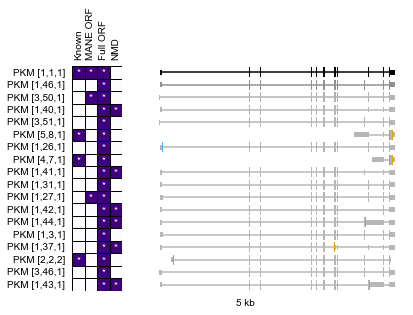

In [51]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        'PKM',
                        obs_col,
                        'ovary',
                        'pkm.pdf')

Read in graph from ../data/human/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2069: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2068: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples
> <ipython-input-47-5809fb885a5b>(293)plot_browser_isos()
    291 
    292     # first add the labels
--> 293     ax = add_bool_heatmap(tpm_df, ax, species)
    294 
    295     # get y coords from heatmap



ipdb>  c


> <ipython-input-47-5809fb885a5b>(48)add_bool_heatmap()
     46     pdb.set_trace()
     47 
---> 48     m = {True: '*', False: ''}
     49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)



ipdb>  c


135.55278425418857


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:354: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


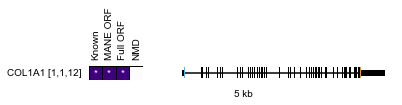

In [52]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        'COL1A1',
                        obs_col,
                        'ovary',
                        'col1a1.pdf')

Read in graph from ../data/human/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples
> <ipython-input-47-5809fb885a5b>(293)plot_browser_isos()
    291 
    292     # first add the labels
--> 293     ax = add_bool_heatmap(tpm_df, ax, species)
    294 
    295     # get y coords from heatmap



ipdb>  c


> <ipython-input-47-5809fb885a5b>(48)add_bool_heatmap()
     46     pdb.set_trace()
     47 
---> 48     m = {True: '*', False: ''}
     49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)



ipdb>  c


63.79015590314102


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:354: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


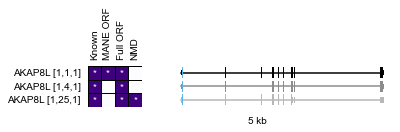

In [53]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        'AKAP8L',
                        obs_col,
                        'h9',
                        'akap8l_h9.pdf')

Read in graph from ../data/human/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples
> <ipython-input-47-5809fb885a5b>(293)plot_browser_isos()
    291 
    292     # first add the labels
--> 293     ax = add_bool_heatmap(tpm_df, ax, species)
    294 
    295     # get y coords from heatmap



ipdb>  c


> <ipython-input-47-5809fb885a5b>(48)add_bool_heatmap()
     46     pdb.set_trace()
     47 
---> 48     m = {True: '*', False: ''}
     49     for c in bool_cols:
     50         temp2[c] = temp[c].map(m)



ipdb>  c


63.79015590314102


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:354: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


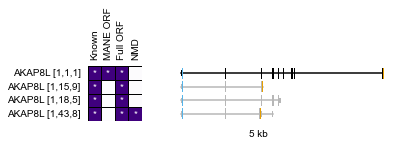

In [54]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        'AKAP8L',
                        obs_col,
                        'h9_panc_progen',
                        'akap8l_h9_panc_progen.pdf')

Read in graph from ../data/human/swan_graph.p
32.54784533263898


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:352: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


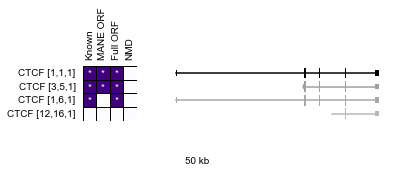

In [57]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        'CTCF',
                        obs_col,
                        'lung',
                        'ctcf.pdf',
                        add_tss=True,
                        add_ccre=True,
                        major=True)

Read in graph from ../data/human/swan_graph.p


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


> <ipython-input-59-09c874e2854b>(53)add_bool_heatmap()
     51     pdb.set_trace()
     52 
---> 53     if species == 'mouse':
     54         temp.drop('MANE ORF', axis=1, inplace=True)
     55         temp2.drop('MANE ORF', axis=1, inplace=True)



ipdb>  temp.head()


              Known  MANE ORF  Full ORF    NMD
                                              
ELN [1,1,3]   False      True     False  False
ELN [1,2,3]   False     False     False  False
ELN [1,76,3]  False     False     False  False
ELN [1,8,3]    True     False     False  False
ELN [1,2,1]   False     False     False  False


ipdb>  c


59.21644796058553


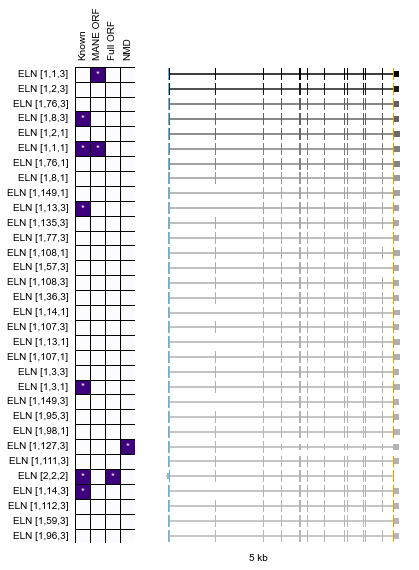

In [60]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        'ELN',
                        obs_col,
                        'lung',
                        'eln.pdf',
                        major=True)

In [62]:
ca = cerberus.read(cerberus_h5)

In [64]:
ca.tss.loc[ca.tss.Name=='ENSG00000049540_1']

,Chromosome,Start,End,Strand,Name,source,novelty,gene_id,tss
55218,chr7,74028050,74028238,+,ENSG00000049540_1,"v40,v29,lapa,gtex,encode_cage,fantom_cage,enco...",Known,ENSG00000049540,1


In [ ]:
"chr7:74028050-74028238"

Read in graph from ../data/human/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2069: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/paper_rnawg/scripts/utils.py:2068: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/fairliereese/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

> <ipython-input-59-09c874e2854b>(53)add_bool_heatmap()
     51     pdb.set_trace()
     52 
---> 53     if species == 'mouse':
     54         temp.drop('MANE ORF', axis=1, inplace=True)
     55         temp2.drop('MANE ORF', axis=1, inplace=True)



ipdb>  c


651.2112529304507


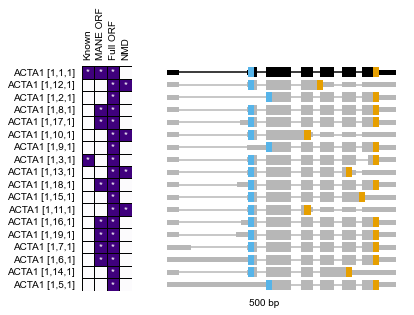

In [65]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        'ACTA1',
                        obs_col,
                        'heart',
                        'acta1.pdf')

Read in graph from ../data/human/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 231136
# isos >= 1 tpm: 210239
Applying gene type and novelty subset
Number of isos reported: 206806
Found 50 total samples
92.7402900916274


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:349: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


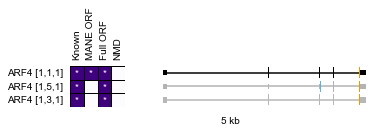

In [18]:
_ = plot_browser_isos_2(cerberus_h5,
                        swan_file,
                        filt_ab,
                        pp_summary,
                        major_isos,
                        'ARF4',
                        obs_col,
                        'h1',
                        'arf4_human.pdf')

Read in graph from ../data/mouse/swan_graph.p
Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 149463
# isos >= 1 tpm: 138642
Applying gene type and novelty subset
Number of isos reported: 135450
Found 37 total samples
92.21689413500553


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:353: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


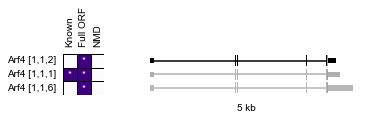

In [33]:
_ = plot_browser_isos_2(m_cerberus_h5,
                        m_swan_file,
                        m_filt_ab,
                        m_pp_summary,
                        m_major_isos,
                        'Arf4',
                        obs_col,
                        'f1219',
                        'arf4_mouse.pdf',
                        species='mouse')

In [38]:
# # within the same exon
# exons = [(-2, -1),(0,2),(3,5),(6,7)]
# orf_start = 1
# orf_end = 1.5
# strand = '+'
# ctrl_cds = [(1, 1.5)] 
# cds = get_cds(exons, orf_start, orf_end, strand)
# assert cds == ctrl_cds

# # skipping first and last exon the same exon
# exons = [(-2, -1),(0,2),(3,5),(6,7)]
# orf_start = 1
# orf_end = 4
# strand = '+'
# ctrl_cds = [(1,2),(3,4)] 
# cds = get_cds(exons, orf_start, orf_end, strand)
# assert cds == ctrl_cds

# # in the first and last exons
# exons = [(0,2),(3,5)]
# orf_start = 1
# orf_end = 4
# strand = '+'
# ctrl_cds = [(1,2),(3,4)] 
# cds = get_cds(exons, orf_start, orf_end, strand)
# assert cds == ctrl_cds

# # minus strand
# exons = [(5,3),(2,0)]
# orf_start = 4
# orf_end = 1
# strand = '-'
# ctrl_cds = [(4,3),(2,1)] 
# cds = get_cds(exons, orf_start, orf_end, strand)
# assert cds == ctrl_cds

# # within the same exon
# exons = [(7,6),(5,3),(2,0),(-1,-2)]
# orf_start = 1.5
# orf_end = 1
# strand = '-'
# ctrl_cds = [(1.5, 1)] 
# cds = get_cds(exons, orf_start, orf_end, strand)
# assert cds == ctrl_cds

# # skipping first and last exon the same exon
# exons = [(7,6),(5,3),(2,0),(-1,-2)]
# orf_start = 4
# orf_end = 1
# strand = '-'
# ctrl_cds = [(4,3),(2,1)] 
# cds = get_cds(exons, orf_start, orf_end, strand)
# assert cds == ctrl_cds